# Logistic Regression for Entire City
The purpose of this notebook is to perform a series of logistic regression models following our conceptual analysis model. For each of the 10 SoP variables, we will perform a univariate logit, followed by multivariate models of the SoP variable and increasing numbers of control variables. An example process follows:
1. Collision_occured(binary dependent variable) = FORM3(SoP independent variable)
2. Collision_occured(DV) = FORM3(IV) + Residential_Population(first control variable)
3. Collision_occured(DV) = FORM3(IV) + Residential_Population(CV) + Number_Travel_Lanes(2nd CV)
...
4. Collision_occured(DV) = FORM3(IV) + (Residential_Population + Number_Travel_Lanes + Work_Population + Distance_to_Subway + ...)

This will be followed by a multivariate model combining all 10 SoP Variables and a similar sequential addition of control variables. The final output will be a table summarizing all of the above with associate $R^2$ & *coeficients* for each model

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np

from scipy.stats.distributions import chi2

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', 150)

from IPython.core.interactiveshell import InteractiveShell

from statsmodels.api import Logit, add_constant
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

#import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

### Part 0: Ingest and Encode Dependent, Independent, and Control Variables

In [2]:
intersections = pd.read_csv('../Data/road_network_data/osm/intersections_final_w_sop/intersections_final.csv')
intersections.head()

,osmid,Total_Inju,Total_Fata,sub_dist,med_inc,norm_res_p,norm_work_,geometry,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,Street_Width,FORM3,DENS2,CONN5,PROX3,PARKS2,PAF2,PEDS3,TRAFFIC5,AESTTOT3,SAFE,SoPIndex6,FORM3_norm,DENS2_norm,CONN5_norm,PROX3_norm,PARKS2_norm,PAF2_norm,PEDS3_norm,TRAFFIC5_norm,AESTTOT3_norm,SAFE_norm,SoPIndex6_norm,Collisions,Collision_Occured
0,42860546,0.0,0.0,1.371429,13.714700,18.525176,0.382706,POINT (1000750.795416632 210205.7528114537),4.0,1.5,2.0,25.0,3.0,40.75,-7.809492,1.793260,-1.056529,0.088352,-1.395603,-0.458275,7.286847,7.465677,6.991727,-6.980700,5.925263,2.249382,59.628458,53.615492,6.600246,0.143733,0.005288,25.162572,64.023970,38.010729,73.023619,39.290709,0.0,0
1,42467330,2.0,0.0,4.582604,4.004433,48.649265,1.256099,POINT (1002652.742108569 177974.3482433519),4.0,2.0,2.0,25.0,0.0,40.00,-3.484622,3.718840,-0.931710,-2.673075,-1.395603,-0.458275,2.801236,7.233681,2.836356,1.412148,9.058976,10.549486,71.300206,53.962696,3.457195,0.143733,0.005288,20.480076,63.564348,33.826127,91.887175,40.444334,2.0,1
2,42467331,1.0,0.0,4.416357,3.880400,57.305828,1.048126,POINT (1002921.868557178 177996.4131735155),4.0,1.5,2.0,25.0,0.0,33.50,-3.544449,2.147821,-1.056529,-4.368950,-1.395603,-0.458275,2.801236,7.465677,3.833468,-0.020003,5.404393,10.434668,61.777602,53.615492,1.526952,0.143733,0.005288,20.480076,64.023970,34.830253,88.668309,39.098959,1.0,1
3,42467333,1.0,0.0,4.247996,5.534925,68.654563,1.268928,POINT (1003181.00656743 178017.3803186663),4.0,1.5,2.0,25.0,0.0,33.00,-3.544449,3.121916,-1.056529,-2.243159,-1.395603,-0.458275,2.333350,7.465677,3.833468,0.151996,8.208391,10.434668,67.682000,53.615492,3.946524,0.143733,0.005288,19.991653,64.023970,34.830253,89.054888,40.131205,1.0,1
4,42467334,23.0,0.0,4.077225,6.210467,63.780911,1.550502,POINT (1003459.565062104 178040.5515355509),4.0,3.0,2.0,25.0,0.0,50.00,0.623103,3.611247,0.165412,7.982746,-1.395603,-0.458275,4.453216,8.519762,3.773186,-4.944856,22.329938,18.432852,70.648042,57.014531,15.585632,0.143733,0.005288,22.204565,66.112289,34.769547,77.599332,45.329821,23.0,1


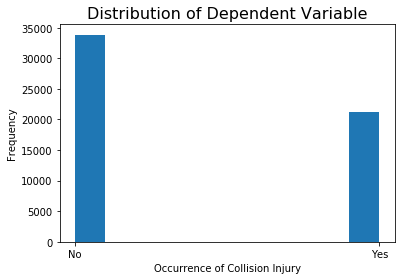

In [3]:
# Look at distribution of DV throughout city
plt.figure(figsize=(6,4))
plt.hist(intersections.Collision_Occured)
plt.title('Distribution of Dependent Variable', fontsize=16)
plt.xticks(range(2), labels=['No', 'Yes'])
plt.xlabel('Occurrence of Collision Injury')
plt.ylabel('Frequency')
plt.show()

In [20]:
# we will look at each of the following individually at first
ind_variables = ['FORM3_norm', 'DENS2_norm', 'CONN5_norm', 'PROX3_norm', 'PARKS2_norm', 
                 'PAF2_norm', 'PEDS3_norm', 'TRAFFIC5_norm', 'AESTTOT3_norm', 'SAFE_norm']

# these are our OPTIONAL control variables, i.e. we do not have to use all of them
# I've ordered them in order of importance
control_variables = ['med_inc', 'norm_res_p', 'norm_work_', 'sub_dist',
                     'Num_Streets', 'Num_Lanes','Num_Park_Lanes', 'Speed_Limit', 'Bike_Lanes', 'Street_Width']

In [21]:
# scale entire dataset
ind_cv = ['SoPIndex6_norm'] + ind_variables + control_variables
X_2 = intersections[ind_cv]

# dependent
y = intersections.Collision_Occured

### Part 1: Check for multicollinearity

In [22]:
def plotCorrMatrix(df, features, title):
    units = pd.read_csv('variables_units.csv', index_col='var').to_dict('index')
    corr_matrix = df.loc[:,features].corr()

    ax = plt.figure(figsize=(10,8)).add_subplot(111)
    cax = ax.imshow(corr_matrix, cmap='coolwarm_r', vmin=-1, vmax=1)
    plt.colorbar(cax)
    ax.set_xticks(range(len(features)))
    ax.set_xticklabels([units[f]['name'] for f in features], rotation=90)
    ax.set_yticks(range(len(features)))
    ax.set_yticklabels([units[f]['name'] for f in features])
    ax.set_title(title)
    
    for i in range(len(corr_matrix.index)):
        for j in range(len(corr_matrix.columns)):
            text = ax.text(j, i, '{:.2f}'.format(corr_matrix.iloc[i, j]),
                           ha="center", va="center", color="k" if abs(corr_matrix.iloc[i, j])<0.9 else "w")

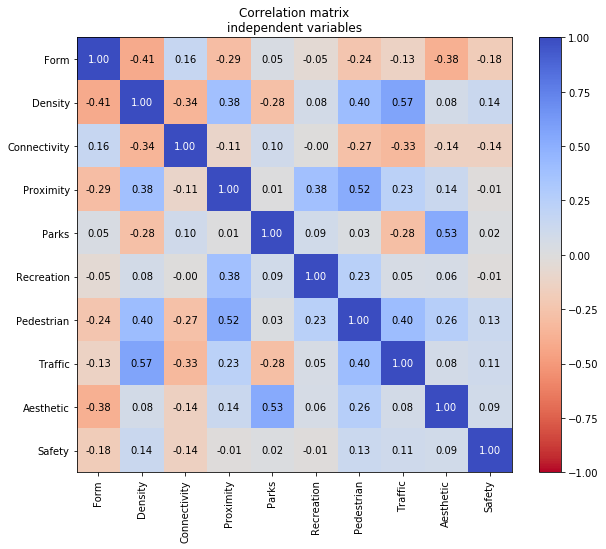

In [80]:
plotCorrMatrix(intersections, ind_variables, 'Correlation matrix\nindependent variables')

**Notes:**

1. As expected, the SoP index is correlated with all variables (because it is the sum of them). But for some reason it is negatively correlated with Form and Connectivity. This might be because this two dimensions are negatively correlated to most of the others.
2. There is high collinearity between some of the SoP dimensions in NYC. This could be a problem when modeling, not sure how to address it as we want to use all of them together.

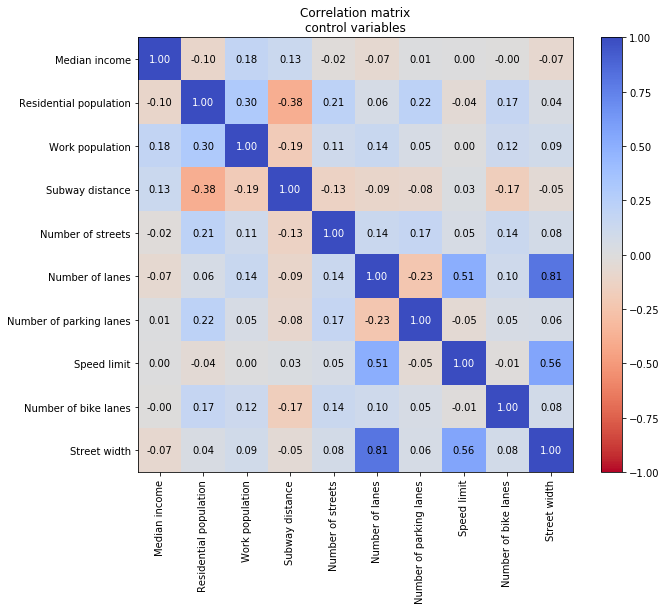

In [24]:
plotCorrMatrix(intersections, control_variables, 'Correlation matrix\ncontrol variables')

**Notes:**

1. The highest correlation is between Street Width and Number of Lanes (positive) followed by Speed Limit also positively correlated with both.
2. Subway distance is negatively correlated with Residential and Work population. More dense places are closer (and have more) subway stations.
3. Finally, residential population is positively correlated with work population.

**We are removing Street Width from the Control Variables because it has too high correlation with Number of Lanes, and it is essentially measuring the same.** Other variables are collinear but we are keeping them because from our conceptual model, they represent different things. We want to avoid ommitted variable issues.

In [26]:
control_variables.remove('Street_Width')

### Part 2: Univariate Models + Sequential Control Variables

In [27]:
report = pd.DataFrame(columns=['Model', 'r2'] + X_2.columns.tolist())
models = {}

In [28]:
def logitReport(x_list, model_name, y=y, X=X_2, report=report, add_const=True):
    """
    Run logit regression and append result to the report
    
    input:
    x_list: a list of covariates
    model_name: a name for the model
    y: a dataframe for dependent variable
    X: a data frame for all independent variables
    report: a report dataframe to append on

    
    return: a new appended report dataframe
    """
    
    if add_const:
        X = add_constant(X.reindex(columns=x_list))
    else:
        X = X.reindex(columns=x_list)
    
    model = Logit(y, X).fit()
    report = report.append(pd.concat([pd.Series({'Model': model_name, 'r2': round(model.prsquared, 3)}), round(model.params, 3)], axis=0).rename('coef'))
    report = report.append(pd.concat([pd.Series({'Model': model_name, 'r2': round(model.prsquared, 3)}), round(model.pvalues, 3)], axis=0).rename('pvalue'))
    
    models[model_name] = model
    
    return report

def getSignificance(df):
    dfT = df.T
    dfT.loc[dfT.index != 'r2','coef'] = dfT.loc[dfT.index != 'r2',:].apply(
        lambda x: ''.join([x['coef'].astype(str), '***']) if x['pvalue'] < 0.001 else \
            (''.join([x['coef'].astype(str), '**']) if x['pvalue'] < 0.01 else \
            (''.join([x['coef'].astype(str), '*']) if x['pvalue'] < 0.05 else x['coef'])), axis=1)
    
    dfT.drop('pvalue', axis=1, inplace=True)
    return dfT.T

def formatReport(report, variable, compare='start'):
    cols=list(report.columns)
    if compare == 'start':
        rep = report[report.Model.str.startswith(variable)].groupby('Model').apply(getSignificance)
    else:
        rep = report[report.Model.str.endswith(variable)].groupby('Model').apply(getSignificance)                                   
    cols.remove('Model')
    rep = rep[cols]
    rep.dropna(axis=1, how='all', inplace=True)
    rep.fillna('', inplace=True)
    rep.index = rep.index.droplevel(1)
    
    return rep

#Function to evaluate
def evalNullHypothesis(p, statistic, test, hypothesis=None,alpha=0.05):
    if hypothesis:
        print ("The Null Hypothesis that {}".format(hypothesis))
    else:
        print ("The Null Hypothesis")
    if p < alpha :
        print ("can be rejected at alpha = {}".format(alpha))
    else: 
        print ("cannot be rejected (p<0.05)")
    print ("with a {} statistics of {:.2f} and a p-value of {:.3f}".format(test, statistic, p))
    
def likelihood_ratio_test(restricted, full):
    
    LR = 2*(full.llf - restricted.llf)
    
    p_value = chi2.sf(LR, full.df_model - restricted.df_model)
    
    return LR, p_value

In [29]:
%%capture 
# above is so we do not print results

# First, univariate models w/out CV's
for idx, field in enumerate(['SoPIndex6_norm'] + ind_variables):
    report = logitReport(x_list=[field], model_name=field, report=report)

In [30]:
formatReport(report, 'norm', 'end').sort_values(['SoPIndex6_norm'] + ind_variables, ascending=False)

,r2,SoPIndex6_norm,FORM3_norm,DENS2_norm,CONN5_norm,PROX3_norm,PARKS2_norm,PAF2_norm,PEDS3_norm,TRAFFIC5_norm,AESTTOT3_norm,SAFE_norm,const
Model,,,,,,,,,,,,,
SoPIndex6_norm,0.115,0.194***,,,,,,,,,,,-8.211***
FORM3_norm,0.026,,-0.091***,,,,,,,,,,0.451***
DENS2_norm,0.028,,,0.031***,,,,,,,,,-2.4***
CONN5_norm,0.012,,,,-0.07***,,,,,,,,3.447***
PROX3_norm,0.171,,,,,0.224***,,,,,,,-1.632***
PARKS2_norm,0.001,,,,,,0.009***,,,,,,-0.499***
PAF2_norm,0.014,,,,,,,0.102***,,,,,-0.541***
PEDS3_norm,0.106,,,,,,,,0.181***,,,,-4.13***
TRAFFIC5_norm,0.011,,,,,,,,,0.04***,,,-2.898***


**Notes:**

From above, all univariate models without control variables are significant to the 0.001 level. However, only Form, Connectivity, and Proximity have the coefficient sign we would expect based on literature and SoP's expert knowledge. The models with highest R2 value are Proximity, Pedestrian, and SoP index.

The flipped sign issue could come from various sources:
1. Lack of control variables
2. Need to include multiple independent variables in a single model
3. Interaction effects and non-linearities not captured by these simple models
4. Low accuracy in the prediction of SoP dimensions

In [31]:
%%capture

# now, univariates with CV's 
for field in ['SoPIndex6_norm'] + ind_variables:
    for i in range(1, len(control_variables)+1): 
        report = logitReport(x_list=[field]+ control_variables[:i], model_name=field+'_cv' + str(i).zfill(2), report=report)

In [32]:
InteractiveShell.ast_node_interactivity = "all"

# want to see how r2, coeff and significance changes with sample field
units = pd.read_csv('variables_units.csv', index_col='var').to_dict('index')

for field in ['SoPIndex6_norm'] + ind_variables:
    print('Results for all {} Univatiate Models'.format(units[field]['name']))
    formatReport(report, field)

Results for all SoP index Univatiate Models


,r2,SoPIndex6_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,const
Model,,,,,,,,,,,,
SoPIndex6_norm,0.115,0.194***,,,,,,,,,,-8.211***
SoPIndex6_norm_cv01,0.132,0.203***,-0.099***,,,,,,,,,-7.891***
SoPIndex6_norm_cv02,0.178,0.145***,-0.073***,0.02***,,,,,,,,-6.496***
SoPIndex6_norm_cv03,0.185,0.129***,-0.087***,0.018***,0.04***,,,,,,,-5.812***
SoPIndex6_norm_cv04,0.193,0.121***,-0.075***,0.015***,0.033***,-0.055***,,,,,,-5.2***
SoPIndex6_norm_cv05,0.266,0.109***,-0.084***,0.013***,0.035***,-0.056***,1.154***,,,,,-8.569***
SoPIndex6_norm_cv06,0.297,0.125***,-0.073***,0.015***,0.022***,-0.051***,1.158***,0.602***,,,,-10.441***
SoPIndex6_norm_cv07,0.302,0.106***,-0.072***,0.015***,0.026***,-0.053***,1.11***,0.679***,0.424***,,,-10.346***
SoPIndex6_norm_cv08,0.302,0.104***,-0.071***,0.015***,0.026***,-0.053***,1.111***,0.72***,0.433***,-0.015***,,-9.985***


Results for all Form dimension Univatiate Models


,r2,FORM3_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,const
Model,,,,,,,,,,,,
FORM3_norm,0.026,-0.091***,,,,,,,,,,0.451***
FORM3_norm_cv01,0.039,-0.098***,-0.076***,,,,,,,,,1.031***
FORM3_norm_cv02,0.134,-0.035***,-0.051***,0.028***,,,,,,,,-0.763***
FORM3_norm_cv03,0.154,-0.031***,-0.079***,0.023***,0.064***,,,,,,,-0.628***
FORM3_norm_cv04,0.166,-0.026***,-0.066***,0.019***,0.054***,-0.065***,,,,,,-0.327***
FORM3_norm_cv05,0.246,-0.01***,-0.072***,0.017***,0.053***,-0.066***,1.203***,,,,,-4.509***
FORM3_norm_cv06,0.273,-0.019***,-0.061***,0.019***,0.042***,-0.063***,1.211***,0.552***,,,,-5.596***
FORM3_norm_cv07,0.287,-0.015***,-0.063***,0.017***,0.044***,-0.064***,1.121***,0.679***,0.655***,,,-6.534***
FORM3_norm_cv08,0.288,-0.014***,-0.062***,0.017***,0.043***,-0.063***,1.123***,0.759***,0.67***,-0.028***,,-6.0***


Results for all Density dimension Univatiate Models


,r2,DENS2_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,const
Model,,,,,,,,,,,,
DENS2_norm,0.028,0.031***,,,,,,,,,,-2.4***
DENS2_norm_cv01,0.040,0.033***,-0.076***,,,,,,,,,-2.022***
DENS2_norm_cv02,0.132,0.009***,-0.048***,0.028***,,,,,,,,-1.676***
DENS2_norm_cv03,0.154,0.01***,-0.079***,0.023***,0.067***,,,,,,,-1.53***
DENS2_norm_cv04,0.166,0.009***,-0.066***,0.019***,0.056***,-0.066***,,,,,,-1.116***
DENS2_norm_cv05,0.246,0.004***,-0.072***,0.017***,0.054***,-0.067***,1.2***,,,,,-4.811***
DENS2_norm_cv06,0.281,0.025***,-0.068***,0.016***,0.043***,-0.06***,1.171***,0.699***,,,,-7.339***
DENS2_norm_cv07,0.289,0.014***,-0.065***,0.016***,0.045***,-0.062***,1.118***,0.738***,0.536***,,,-7.43***
DENS2_norm_cv08,0.290,0.014***,-0.064***,0.016***,0.044***,-0.061***,1.119***,0.811***,0.553***,-0.027***,,-6.889***


Results for all Connectivity dimension Univatiate Models


,r2,CONN5_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,const
Model,,,,,,,,,,,,
CONN5_norm,0.012,-0.07***,,,,,,,,,,3.447***
CONN5_norm_cv01,0.021,-0.072***,-0.065***,,,,,,,,,4.015***
CONN5_norm_cv02,0.136,-0.052***,-0.046***,0.029***,,,,,,,,1.703***
CONN5_norm_cv03,0.158,-0.061***,-0.079***,0.023***,0.069***,,,,,,,2.453***
CONN5_norm_cv04,0.171,-0.064***,-0.065***,0.019***,0.058***,-0.068***,,,,,,2.992***
CONN5_norm_cv05,0.248,0.046***,-0.067***,0.018***,0.051***,-0.066***,1.269***,,,,,-7.427***
CONN5_norm_cv06,0.282,-0.168***,-0.06***,0.019***,0.043***,-0.067***,1.091***,0.942***,,,,3.214***
CONN5_norm_cv07,0.293,-0.131***,-0.061***,0.017***,0.045***,-0.067***,1.01***,0.978***,0.593***,,,0.479
CONN5_norm_cv08,0.294,-0.128***,-0.061***,0.017***,0.044***,-0.066***,1.017***,1.035***,0.602***,-0.024***,,0.777*


Results for all Proximity dimension Univatiate Models


,r2,PROX3_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,const
Model,,,,,,,,,,,,
PROX3_norm,0.171,0.224***,,,,,,,,,,-1.632***
PROX3_norm_cv01,0.183,0.222***,-0.084***,,,,,,,,,-1.086***
PROX3_norm_cv02,0.223,0.179***,-0.068***,0.019***,,,,,,,,-1.658***
PROX3_norm_cv03,0.224,0.174***,-0.072***,0.018***,0.014***,,,,,,,-1.611***
PROX3_norm_cv04,0.229,0.166***,-0.064***,0.016***,0.011***,-0.044***,,,,,,-1.334***
PROX3_norm_cv05,0.298,0.157***,-0.075***,0.014***,0.014***,-0.043***,1.161***,,,,,-5.149***
PROX3_norm_cv06,0.322,0.157***,-0.064***,0.016***,0.006**,-0.04***,1.167***,0.54***,,,,-6.319***
PROX3_norm_cv07,0.329,0.147***,-0.065***,0.015***,0.009***,-0.042***,1.102***,0.636***,0.479***,,,-6.934***
PROX3_norm_cv08,0.330,0.147***,-0.065***,0.014***,0.009***,-0.041***,1.103***,0.671***,0.485***,-0.012***,,-6.702***


Results for all Parks dimension Univatiate Models


,r2,PARKS2_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,const
Model,,,,,,,,,,,,
PARKS2_norm,0.001,0.009***,,,,,,,,,,-0.499***
PARKS2_norm_cv01,0.009,0.007***,-0.061***,,,,,,,,,-0.088***
PARKS2_norm_cv02,0.130,0,-0.044***,0.029***,,,,,,,,-1.228***
PARKS2_norm_cv03,0.152,-0.007***,-0.075***,0.025***,0.067***,,,,,,,-0.998***
PARKS2_norm_cv04,0.165,-0.01***,-0.062***,0.02***,0.056***,-0.067***,,,,,,-0.607***
PARKS2_norm_cv05,0.246,-0.002,-0.07***,0.017***,0.054***,-0.067***,1.207***,,,,,-4.631***
PARKS2_norm_cv06,0.274,-0.021***,-0.059***,0.02***,0.044***,-0.065***,1.205***,0.577***,,,,-5.765***
PARKS2_norm_cv07,0.286,-0.003,-0.061***,0.018***,0.045***,-0.065***,1.128***,0.677***,0.651***,,,-6.718***
PARKS2_norm_cv08,0.287,-0.003,-0.06***,0.017***,0.044***,-0.064***,1.13***,0.758***,0.667***,-0.028***,,-6.17***


Results for all Recreation dimension Univatiate Models


,r2,PAF2_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,const
Model,,,,,,,,,,,,
PAF2_norm,0.014,0.102***,,,,,,,,,,-0.541***
PAF2_norm_cv01,0.025,0.114***,-0.073***,,,,,,,,,-0.07***
PAF2_norm_cv02,0.139,0.086***,-0.052***,0.029***,,,,,,,,-1.22***
PAF2_norm_cv03,0.155,0.061***,-0.076***,0.025***,0.06***,,,,,,,-1.049***
PAF2_norm_cv04,0.167,0.056***,-0.063***,0.021***,0.05***,-0.065***,,,,,,-0.68***
PAF2_norm_cv05,0.249,0.064***,-0.073***,0.018***,0.049***,-0.065***,1.216***,,,,,-4.701***
PAF2_norm_cv06,0.275,0.06***,-0.061***,0.02***,0.038***,-0.062***,1.227***,0.54***,,,,-5.89***
PAF2_norm_cv07,0.289,0.06***,-0.063***,0.018***,0.041***,-0.063***,1.134***,0.67***,0.658***,,,-6.773***
PAF2_norm_cv08,0.290,0.059***,-0.062***,0.018***,0.04***,-0.062***,1.136***,0.749***,0.671***,-0.028***,,-6.232***


Results for all Pedestrian dimension Univatiate Models


,r2,PEDS3_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,const
Model,,,,,,,,,,,,
PEDS3_norm,0.106,0.181***,,,,,,,,,,-4.13***
PEDS3_norm_cv01,0.123,0.192***,-0.1***,,,,,,,,,-3.694***
PEDS3_norm_cv02,0.178,0.139***,-0.073***,0.022***,,,,,,,,-3.584***
PEDS3_norm_cv03,0.189,0.128***,-0.094***,0.019***,0.049***,,,,,,,-3.238***
PEDS3_norm_cv04,0.197,0.12***,-0.081***,0.016***,0.042***,-0.053***,,,,,,-2.81***
PEDS3_norm_cv05,0.264,0.095***,-0.087***,0.014***,0.044***,-0.056***,1.13***,,,,,-6.105***
PEDS3_norm_cv06,0.295,0.11***,-0.077***,0.016***,0.031***,-0.05***,1.134***,0.605***,,,,-7.681***
PEDS3_norm_cv07,0.301,0.093***,-0.075***,0.015***,0.034***,-0.053***,1.083***,0.688***,0.462***,,,-8.027***
PEDS3_norm_cv08,0.301,0.091***,-0.074***,0.015***,0.034***,-0.052***,1.086***,0.732***,0.471***,-0.016***,,-7.686***


Results for all Traffic dimension Univatiate Models


,r2,TRAFFIC5_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,const
Model,,,,,,,,,,,,
TRAFFIC5_norm,0.011,0.04***,,,,,,,,,,-2.898***
TRAFFIC5_norm_cv01,0.020,0.043***,-0.067***,,,,,,,,,-2.598***
TRAFFIC5_norm_cv02,0.133,0.022***,-0.047***,0.029***,,,,,,,,-2.548***
TRAFFIC5_norm_cv03,0.154,0.023***,-0.077***,0.024***,0.067***,,,,,,,-2.384***
TRAFFIC5_norm_cv04,0.167,0.024***,-0.064***,0.02***,0.056***,-0.067***,,,,,,-2.074***
TRAFFIC5_norm_cv05,0.247,0.018***,-0.072***,0.017***,0.054***,-0.067***,1.194***,,,,,-5.639***
TRAFFIC5_norm_cv06,0.283,0.056***,-0.06***,0.019***,0.042***,-0.064***,1.176***,0.699***,,,,-9.323***
TRAFFIC5_norm_cv07,0.287,0.024***,-0.061***,0.018***,0.044***,-0.065***,1.133***,0.709***,0.497***,,,-8.015***
TRAFFIC5_norm_cv08,0.288,0.018***,-0.06***,0.018***,0.043***,-0.064***,1.133***,0.765***,0.546***,-0.022***,,-7.269***


Results for all Aesthetic dimension Univatiate Models


,r2,AESTTOT3_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,const
Model,,,,,,,,,,,,
AESTTOT3_norm,0.006,0.055***,,,,,,,,,,-2.374***
AESTTOT3_norm_cv01,0.016,0.063***,-0.068***,,,,,,,,,-2.199***
AESTTOT3_norm_cv02,0.132,0.027***,-0.047***,0.029***,,,,,,,,-2.141***
AESTTOT3_norm_cv03,0.152,0.017***,-0.075***,0.024***,0.065***,,,,,,,-1.59***
AESTTOT3_norm_cv04,0.164,0.011**,-0.062***,0.02***,0.055***,-0.066***,,,,,,-1.021***
AESTTOT3_norm_cv05,0.246,-0.021***,-0.069***,0.018***,0.055***,-0.068***,1.219***,,,,,-3.97***
AESTTOT3_norm_cv06,0.273,-0.022***,-0.056***,0.02***,0.044***,-0.065***,1.234***,0.546***,,,,-5.16***
AESTTOT3_norm_cv07,0.287,-0.02***,-0.059***,0.018***,0.045***,-0.066***,1.139***,0.674***,0.657***,,,-6.105***
AESTTOT3_norm_cv08,0.288,-0.019***,-0.058***,0.018***,0.044***,-0.064***,1.141***,0.754***,0.671***,-0.028***,,-5.597***


Results for all Safety dimension Univatiate Models


,r2,SAFE_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,const
Model,,,,,,,,,,,,
SAFE_norm,0.006,0.025***,,,,,,,,,,-2.511***
SAFE_norm_cv01,0.015,0.027***,-0.066***,,,,,,,,,-2.28***
SAFE_norm_cv02,0.130,-0.001,-0.044***,0.029***,,,,,,,,-1.167***
SAFE_norm_cv03,0.152,-0.001,-0.074***,0.025***,0.066***,,,,,,,-0.942***
SAFE_norm_cv04,0.164,0.001,-0.061***,0.02***,0.055***,-0.066***,,,,,,-0.703***
SAFE_norm_cv05,0.246,-0.008***,-0.069***,0.018***,0.054***,-0.066***,1.215***,,,,,-4.003***
SAFE_norm_cv06,0.272,-0.005**,-0.057***,0.02***,0.043***,-0.064***,1.225***,0.543***,,,,-5.5***
SAFE_norm_cv07,0.287,-0.01***,-0.059***,0.018***,0.045***,-0.064***,1.134***,0.673***,0.675***,,,-5.978***
SAFE_norm_cv08,0.288,-0.01***,-0.058***,0.018***,0.044***,-0.063***,1.136***,0.754***,0.689***,-0.029***,,-5.42***


**Notes:**

1. Only a few coefficients in all the models are not significant at the 0.001 level. This is usually a good sign, but might just be because we are looking at the whole population and not a small sample (we have 55,161 data points). With large samples p-values tend to get very small and significant, so we sould look also at the size of the coefficient as an indicator of how relevant a feature really is. (more information about this issue on [this paper](https://pdfs.semanticscholar.org/262b/854628d8e2b073816935d82b5095e1703977.pdf))
2. All Univariate models with all CVs have a similar R2 (0.290-0.330), maybe due to the CVs doing much of the work. The best R2 is from the model with the Proximity dimension.
3. Some models flip the sign of the dimension coefficient as we add more CVs. Parks, Aesthetics, and Safety go from positive to negative

### Part 3: Multivariate Model + Sequential Control Variables

In [33]:
# here's with all of the SoP variables Together
report = logitReport(x_list=ind_variables, model_name='Multiv', report=report)

Optimization terminated successfully.
         Current function value: 0.532049
         Iterations 6


In [34]:
%%capture

# now, multivariabe with increasing # of CV's 
for i in range(1, len(control_variables)+1):      
    report = logitReport(x_list=ind_variables+ control_variables[:i], model_name='Multiv_cv' + str(i).zfill(2), report=report)

In [35]:
formatReport(report, 'Multi')

,r2,FORM3_norm,DENS2_norm,CONN5_norm,PROX3_norm,PARKS2_norm,PAF2_norm,PEDS3_norm,TRAFFIC5_norm,AESTTOT3_norm,SAFE_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,const
Model,,,,,,,,,,,,,,,,,,,,,
Multiv,0.202,-0.022***,-0.012***,-0.038***,0.202***,0.007**,-0.027***,0.101***,-0.018***,-0.026***,0.028***,,,,,,,,,,-0.831*
Multiv_cv01,0.218,-0.026***,-0.011***,-0.037***,0.194***,-0,-0.016***,0.108***,-0.02***,-0.013**,0.031***,-0.103***,,,,,,,,,-0.874**
Multiv_cv02,0.244,-0.01**,-0.022***,-0.045***,0.174***,-0.012***,-0.012**,0.085***,-0.011***,-0.003,0.017***,-0.079***,0.018***,,,,,,,,0.219
Multiv_cv03,0.244,-0.009**,-0.022***,-0.046***,0.171***,-0.013***,-0.012**,0.084***,-0.011***,-0.003,0.017***,-0.082***,0.017***,0.008***,,,,,,,0.317
Multiv_cv04,0.248,-0.007*,-0.022***,-0.049***,0.165***,-0.014***,-0.013**,0.079***,-0.009***,-0.005,0.017***,-0.073***,0.015***,0.006**,-0.04***,,,,,,0.728*
Multiv_cv05,0.311,-0.004,-0.015***,0.065***,0.157***,0.005*,-0.008,0.064***,0.011***,-0.039***,0.013***,-0.074***,0.014***,0.007***,-0.038***,1.236***,,,,,-9.71***
Multiv_cv06,0.334,0.005,-0.005***,-0.089***,0.14***,-0.002,-0.006,0.055***,0.013***,-0.031***,0.011***,-0.071***,0.014***,0.006**,-0.04***,1.055***,0.796***,,,,-2.768***
Multiv_cv07,0.337,0.002,-0.007***,-0.094***,0.141***,0.005,-0.006,0.05***,-0.013***,-0.038***,0.008***,-0.069***,0.014***,0.007***,-0.041***,1.013***,0.802***,0.475***,,,-0.826
Multiv_cv08,0.338,0.002,-0.007***,-0.094***,0.141***,0.005,-0.006,0.049***,-0.015***,-0.037***,0.008***,-0.069***,0.014***,0.007***,-0.041***,1.014***,0.822***,0.49***,-0.007*,,-0.593


**Notes:**

1. The Multivariate model without any control variables shows all SoP dimensions to be significant. Also, most SoP dimensions now have the sign we would expect but not all.
    - Parks: coefficient is positive but the smallest of all dimensions (0.007) which indicates its impact on collisions is almost negligible
    - Pedestrians: coefficient is positive and high (0.101) which is definitely contrary to whats expected
    - Safety: coefficient is positive (0.028)
2. The Multivariate model with all control variables shows some of the SoP dimensions no longer to be significant.
    - Form: Not significant and coefficient almost 0.
    - Parks: Not signifficant and smaller than before (0.005)
    - Peds: still positive but smaller coefficient than before.
    - Safe: still positive but coefficient almost 0.
3. R2 of the Multivariate model with all CVs is the highest so far (0.338), but close to the R2 from the Univariate model of Proximity with all CVs (0.330).
4. About Control Variables:
    - Most CVs are significant. Bike Lanes is not significant. Speed Limit's coefficient is almost 0 and the least significant (0.05). As Mariela said, this indicates that just reducing speed would not impact collisions: street design matters more. High correlation with Number of Lanes might also be affecting, and also the fact that speed limit distribution does'nt have a lot of variance in NYC and is already low.

### Part 4: Model interpretation

Useful links with step by step explanation of how to interpret odds ratios:

https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/

https://stats.idre.ucla.edu/stata/seminars/deciphering-interactions-in-logistic-regression/

#### How much does the odds of collision change with a 1 unit increase for each variable?

In [144]:
def reportLogitInterpretation(model):
    #get units from file
    units = pd.read_csv('variables_units.csv', index_col='var').to_dict('index')

    #get coeficients and CI
    res = pd.concat([model.params, model.pvalues, model.conf_int()], axis=1)

    res.columns = ['exp(coef)', 'pvalue', '[0.025', '0.975]']

    #Transform to change in odds (all but pvalue)
    res.loc[:,['exp(coef)', '[0.025', '0.975]']] = (np.exp(res.loc[:,['exp(coef)', '[0.025', '0.975]']]))

    #Make pvalue easier to read
    res['pvalue'] = res['pvalue'].apply(lambda x: '{:.3f}'.format(x))

    #Add interpretation
    res['interpretation'] = res.apply(lambda x: 'a {} increase in {} is associated with a {:.1f}% change in the odds of collision'.format(
                                                        units[x.name]['unit'],units[x.name]['name'],100*(x['exp(coef)']-1))
                                                        if ((x.name not in ['const','Intercept']) and ':' not in x.name) else '', axis=1)
    return res

def plotProbability(ax, X, model, var, model_name, is_dim=True):
    #get units from file
    units = pd.read_csv('variables_units.csv', index_col='var').to_dict('index')
    
    #Get stats for each variable
    stats = X.describe().T
    
    #Get model coefficients
    coefs = model.params
    
    #i_term = coefs['PEDS3_norm:PROX3_norm']

    #Get list of other variables in the model (all but the one we are ploting)
    other_vars = list(coefs[1:].index)
    other_vars.remove(var)
    
    #Calculate the odds for each level of the variable we want, keeping the others at their mean (+- 1std)
    if (is_dim):
        x = range(1,101)
    else:
        x = range(int(np.floor(stats.loc[var,'min'])), int(np.ceil(stats.loc[var,'max'])))
    odds_mean = np.exp(coefs[0] + np.sum(coefs[other_vars]*stats.loc[other_vars,'mean']) + coefs[var]*x)
                      #+ i_term*stats.loc['PEDS3_norm','mean']*stats.loc['PROX3_norm','mean'])
    
    odds_std1 = np.exp(coefs[0] + np.sum(coefs[other_vars]*(stats.loc[other_vars,'mean']+stats.loc[other_vars,'std'])) + coefs[var]*x)
                       #+ i_term*(stats.loc['PEDS3_norm','mean']+stats.loc['PEDS3_norm','std'])*(stats.loc['PROX3_norm','mean']+stats.loc['PROX3_norm','std']))
    odds_std2 = np.exp(coefs[0] + np.sum(coefs[other_vars]*(stats.loc[other_vars,'mean']-stats.loc[other_vars,'std'])) + coefs[var]*x)
                       #+ i_term*(stats.loc['PEDS3_norm','mean']-stats.loc['PEDS3_norm','std'])*(stats.loc['PROX3_norm','mean']-stats.loc['PROX3_norm','std']))

    #Transform to probability
    p_mean = odds_mean/(1+odds_mean)
    p_std1 = odds_std1/(1+odds_std1)
    p_std2 = odds_std2/(1+odds_std2)

    if (is_dim):
        ax.plot(x, p_mean, label=model_name)
        ax.fill_between(x, p_std1, p_std2, alpha=0.1)
    else:
        ax.plot(x, p_mean, label=model_name, c='tab:blue')
        ax.fill_between(x, p_std1, p_std2, alpha=0.1, color='tab:blue')
    
    #Actual min max of the dimension
    if (is_dim):
        ax.axvline(stats.loc[var,'min'], ls='--', alpha=0.2, color='k')
        ax.axvline(stats.loc[var,'max'], ls='--', alpha=0.2, color='k')
    
    ax.set_title('Probability of collision when {} changes\nkeeping all other variables constant at their average level'.format(units[var]['name']))
    ax.set_ylabel('prob of collision')
    ax.set_xlabel('dimension value')

In [37]:
reportLogitInterpretation(models['Multiv'])

,exp(coef),pvalue,[0.025,0.975],interpretation
const,0.435622,0.010,0.232084,0.817665,
FORM3_norm,0.977918,0.000,0.972510,0.983356,a 1 unit increase in Form dimension is associated with a -2.2% change in the odds of collision
DENS2_norm,0.988010,0.000,0.985889,0.990136,a 1 unit increase in Density dimension is associated with a -1.2% change in the odds of collision
CONN5_norm,0.963112,0.000,0.956964,0.969299,a 1 unit increase in Connectivity dimension is associated with a -3.7% change in the odds of collision
PROX3_norm,1.223754,0.000,1.216653,1.230897,a 1 unit increase in Proximity dimension is associated with a 22.4% change in the odds of collision
PARKS2_norm,1.007141,0.003,1.002443,1.011862,a 1 unit increase in Parks dimension is associated with a 0.7% change in the odds of collision
PAF2_norm,0.973561,0.000,0.965326,0.981866,a 1 unit increase in Recreation dimension is associated with a -2.6% change in the odds of collision
PEDS3_norm,1.106264,0.000,1.099910,1.112655,a 1 unit increase in Pedestrian dimension is associated with a 10.6% change in the odds of collision
TRAFFIC5_norm,0.982130,0.000,0.977976,0.986301,a 1 unit increase in Traffic dimension is associated with a -1.8% change in the odds of collision
AESTTOT3_norm,0.974020,0.000,0.965473,0.982643,a 1 unit increase in Aesthetic dimension is associated with a -2.6% change in the odds of collision


In [39]:
reportLogitInterpretation(models['Multiv_cv09'])

,exp(coef),pvalue,[0.025,0.975],interpretation
const,0.542029,0.236,0.196687,1.493717,
FORM3_norm,1.001803,0.579,0.995455,1.008192,a 1 unit increase in Form dimension is associated with a 0.2% change in the odds of collision
DENS2_norm,0.992872,0.000,0.990298,0.995452,a 1 unit increase in Density dimension is associated with a -0.7% change in the odds of collision
CONN5_norm,0.910416,0.000,0.898504,0.922485,a 1 unit increase in Connectivity dimension is associated with a -9.0% change in the odds of collision
PROX3_norm,1.150925,0.000,1.143616,1.158280,a 1 unit increase in Proximity dimension is associated with a 15.1% change in the odds of collision
PARKS2_norm,1.005254,0.063,0.999709,1.010829,a 1 unit increase in Parks dimension is associated with a 0.5% change in the odds of collision
PAF2_norm,0.993804,0.193,0.984554,1.003141,a 1 unit increase in Recreation dimension is associated with a -0.6% change in the odds of collision
PEDS3_norm,1.053668,0.000,1.045547,1.061852,a 1 unit increase in Pedestrian dimension is associated with a 5.4% change in the odds of collision
TRAFFIC5_norm,0.985127,0.000,0.979008,0.991283,a 1 unit increase in Traffic dimension is associated with a -1.5% change in the odds of collision
AESTTOT3_norm,0.963462,0.000,0.953764,0.973259,a 1 unit increase in Aesthetic dimension is associated with a -3.7% change in the odds of collision


**Note:** These are the same as in Part 3 but the coefficients are exponentiated so they can be interpreted as change in odds.

#### How much does the probabilty of collision change with a 1 unit increase for each variable?

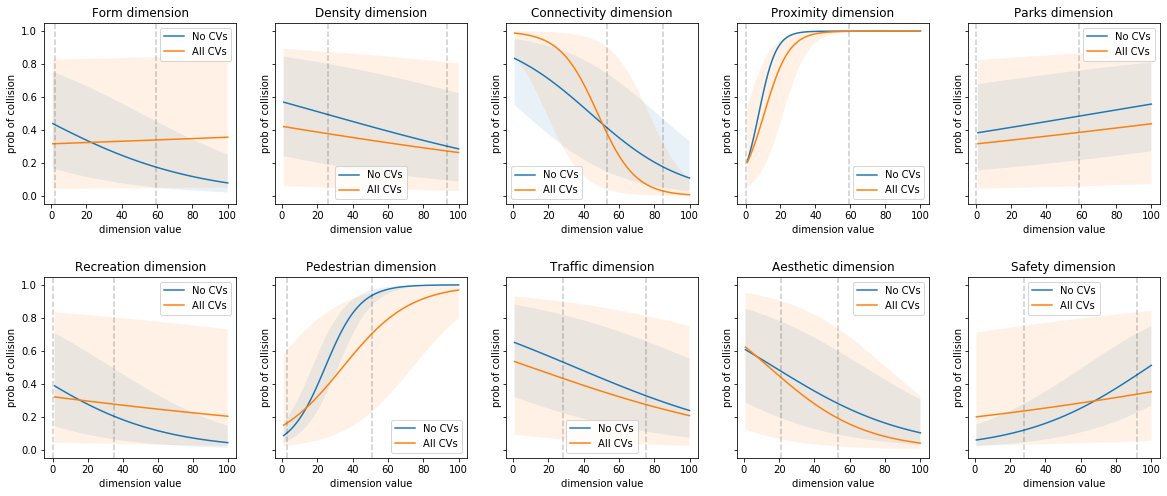

In [41]:
InteractiveShell.ast_node_interactivity = 'last_expr'

fig, axes = plt.subplots(2,5,figsize=(20,8), sharey=True)
plt.subplots_adjust(hspace=0.4)

for i, dim in enumerate(ind_variables):
    ax = axes.flatten()[i]
    
    plotProbability(ax, X_2, models['Multiv'], dim, 'No CVs')
    plotProbability(ax, X_2, models['Multiv_cv09'], dim, 'All CVs')
    
    ax.set_title(units[dim]['name'])
    ax.legend()

plt.show()

This group of plots shows how the probability of collision changes when theoretically changing a specific dimension from 0 to 100, while keeping all other dimensions and CVs constant. The solid line is when other variables are fixed at their mean value, while the shaded area limits are when other variables are fixed at their mean plus/minus 1 standard deviation. The grayed lines show the actual minimum and maximum values of the given dimension in our data.

**Notes:**

1. What stands out the most from the plots above, is that Proximity is by far the dimension that most affects the probability of collision. Most of the variability of collision probability depends on that variable. Proximity increases the probability of collision, which is in line with literature and SoP expertise.
2. Following come Connectivity and Pedestrian dimensions. But we still have the issue of Pedestrian amenities increasing the probability of collisions.
3. Both comments above can also be seen in the tables that come before: those 3 dimensions are the ones that have higher coefficients. However, I think it is important to understand how little some dimensions affect the probability of collision.

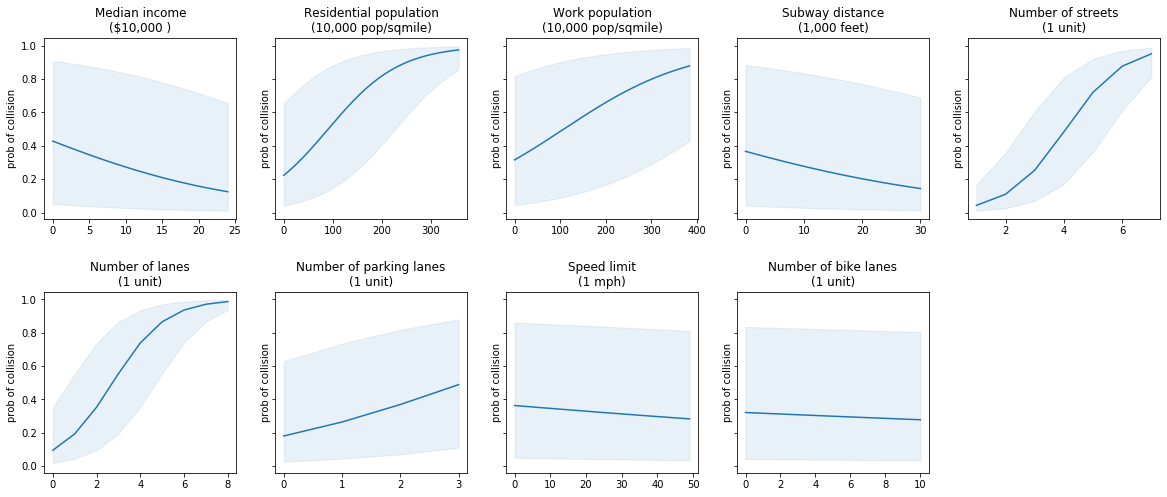

In [139]:
fig, axes = plt.subplots(2,5,figsize=(20,8), sharey=True)
plt.subplots_adjust(hspace=0.4)

for i, dim in enumerate(control_variables):
    ax = axes.flatten()[i]
    
    plotProbability(ax, X_2, models['Multiv_cv09'], dim, 'All CVs', is_dim=False)
    
    ax.set_title('{}\n({})'.format(units[dim]['name'], units[dim]['unit']))
    ax.set_xlabel('')
    
axes.flatten()[-1].axis('off')

plt.show()

Same plot as before but now for all control variables.

**Notes:**
1. Number of lanes and number of streets have by far the highest impact in the probability of collision.

### Part 5: Proximity interaction term

In [44]:
#Only add Pedestrian*Proximity interaction term to the Multivariate model with all CVs
formula = 'Collision_Occured ~ ' + ' + '.join(
    ind_variables +
    ['PEDS3_norm*PROX3_norm'] +
    control_variables)
formula

'Collision_Occured ~ FORM3_norm + DENS2_norm + CONN5_norm + PROX3_norm + PARKS2_norm + PAF2_norm + PEDS3_norm + TRAFFIC5_norm + AESTTOT3_norm + SAFE_norm + PEDS3_norm*PROX3_norm + med_inc + norm_res_p + norm_work_ + sub_dist + Num_Streets + Num_Lanes + Num_Park_Lanes + Speed_Limit + Bike_Lanes'

In [45]:
logit_interaction = smf.logit(formula=formula, data = intersections).fit()
logit_interaction.summary()

Optimization terminated successfully.
         Current function value: 0.440960
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      Collision_Occured   No. Observations:                55161
Model:                          Logit   Df Residuals:                    55140
Method:                           MLE   Df Model:                           20
Date:                Tue, 23 Jul 2019   Pseudo R-squ.:                  0.3389
Time:                        19:38:53   Log-Likelihood:                -24324.
converged:                       True   LL-Null:                       -36793.
                                        LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.2848      0.523     -2.456      0.014      -2.310      -0.259
FORM3_norm            -3.423e-05      0.003     -0.011      0.992      -0.006       0.006
DENS2_norm               -0.0079      0.001     -5.955      0.000      -0.011      -0.005
CONN5_norm               -0.0903      0.007    -13.368      0.000      -0.104      -0.077
PROX3_norm                0.2444      0.010     23.529      0.000       0.224       0.265
PARKS2_norm               0.0038      0.003      1.334      0.182      -0.002       0.009
PAF2_norm                -0.0041      0.005     -0.867      0.386      -0.013       0.005
PEDS3_norm                0.0869      0.005     16.615      0.000       0.077       0.097
TRAFFIC5_norm            -0.0186      0.003     -5.789      0.000      -0.025      -0.012
AESTTOT3_norm            -0.0364      0.005     -7.047      0.000      -0.047      -0.026
SAFE_norm                 0.0077      0.002      4.364      0.000       0.004       0.011
PEDS3_norm:PROX3_norm    -0.0047      0.000    -10.707      0.000      -0.006      -0.004
med_inc                  -0.0672      0.004    -19.035      0.000      -0.074      -0.060
norm_res_p                0.0136      0.000     28.995      0.000       0.013       0.015
norm_work_                0.0087      0.002      4.538      0.000       0.005       0.013
sub_dist                 -0.0403      0.003    -15.809      0.000      -0.045      -0.035
Num_Streets               1.0220      0.021     48.283      0.000       0.981       1.063
Num_Lanes                 0.8168      0.023     35.850      0.000       0.772       0.861
Num_Park_Lanes            0.4864      0.031     15.549      0.000       0.425       0.548
Speed_Limit              -0.0072      0.004     -2.050      0.040      -0.014      -0.000
Bike_Lanes               -0.0285      0.015     -1.916      0.055      -0.058       0.001
=========================================================================================
"""

#### Interpretation

In [46]:
reportLogitInterpretation(logit_interaction)

,exp(coef),pvalue,[0.025,0.975],interpretation
Intercept,0.276717,0.014,0.099242,0.771572,
FORM3_norm,0.999966,0.992,0.993627,1.006345,a 1 unit increase in Form dimension is associated with a -0.0% change in the odds of collision
DENS2_norm,0.992123,0.000,0.989544,0.994709,a 1 unit increase in Density dimension is associated with a -0.8% change in the odds of collision
CONN5_norm,0.913667,0.000,0.901652,0.925843,a 1 unit increase in Connectivity dimension is associated with a -8.6% change in the odds of collision
PROX3_norm,1.276796,0.000,1.251071,1.303051,a 1 unit increase in Proximity dimension is associated with a 27.7% change in the odds of collision
PARKS2_norm,1.003778,0.182,0.998232,1.009355,a 1 unit increase in Parks dimension is associated with a 0.4% change in the odds of collision
PAF2_norm,0.995937,0.386,0.986817,1.005142,a 1 unit increase in Recreation dimension is associated with a -0.4% change in the odds of collision
PEDS3_norm,1.090817,0.000,1.079689,1.102061,a 1 unit increase in Pedestrian dimension is associated with a 9.1% change in the odds of collision
TRAFFIC5_norm,0.981591,0.000,0.975435,0.987785,a 1 unit increase in Traffic dimension is associated with a -1.8% change in the odds of collision
AESTTOT3_norm,0.964271,0.000,0.954562,0.974078,a 1 unit increase in Aesthetic dimension is associated with a -3.6% change in the odds of collision


**Note:** The coefficient of Pedestrian and Proximity should not be interpreted directly from the table because they are interdependent through the interaction term.

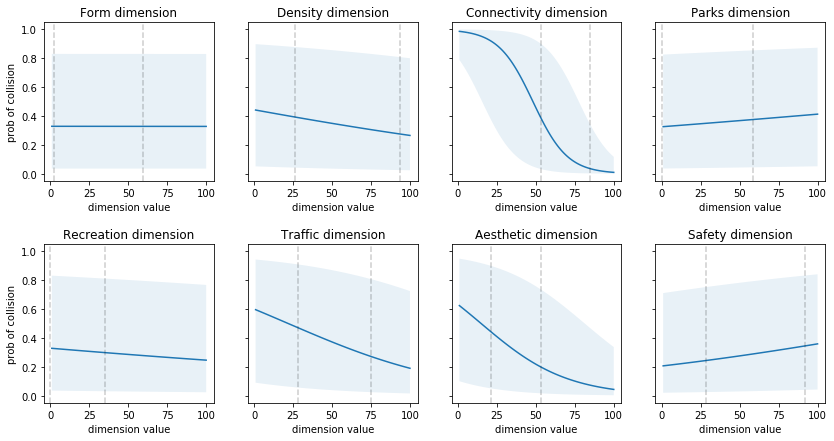

In [145]:
InteractiveShell.ast_node_interactivity = 'last_expr'

fig, axes = plt.subplots(2,4,figsize=(14,7), sharey=True)
plt.subplots_adjust(hspace=0.4)

linear_vars = ind_variables.copy()
linear_vars.remove('PEDS3_norm')
linear_vars.remove('PROX3_norm')

for i, dim in enumerate(linear_vars):
    ax = axes.flatten()[i]
    
    plotProbability(ax, X_2, logit_interaction, dim, 'Multiv_interaction')
    
    ax.set_title(units[dim]['name'])
    
    if i not in [0,4]:
        ax.set_ylabel('')
    #ax.legend()

plt.show()

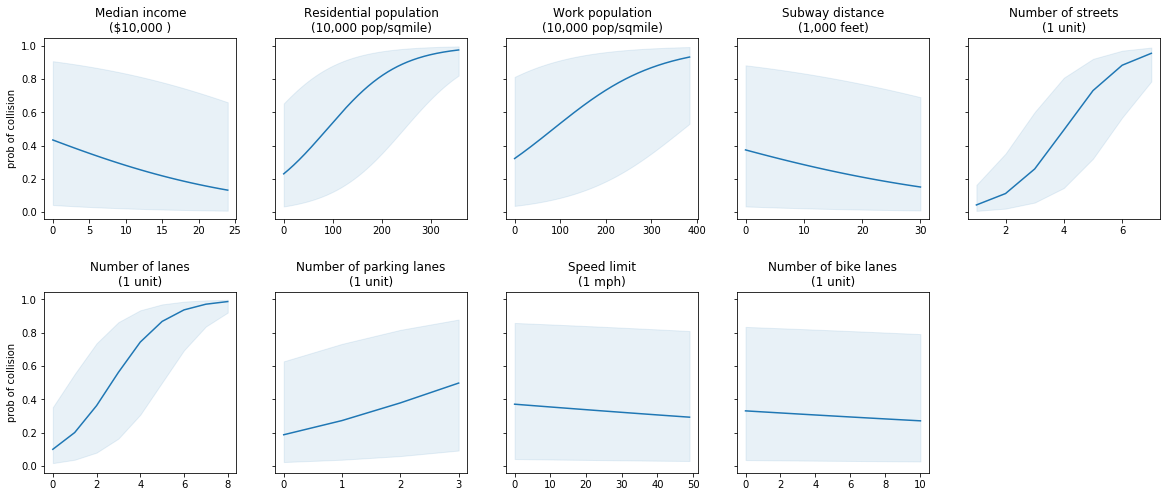

In [146]:
fig, axes = plt.subplots(2,5,figsize=(20,8), sharey=True)
plt.subplots_adjust(hspace=0.4)

for i, dim in enumerate(control_variables):
    ax = axes.flatten()[i]
    
    plotProbability(ax, X_2, logit_interaction, dim, 'All CVs', is_dim=False)
    
    ax.set_title('{}\n({})'.format(units[dim]['name'], units[dim]['unit']))
    ax.set_xlabel('')
    
    if i not in [0,5]:
        ax.set_ylabel('')
    
axes.flatten()[-1].axis('off')

plt.show()

The interaction term means that the coefficient for Pedestrian now depends on Proximity.

PEDS = Bpeds + Bprox\*PROX

Using this formula we can find how the Pedestrian coefficient changes as Proximity changes, and also at which value of Proximity the Pedestrian coefficient goes from negative to positive.

In [49]:
segs_scores = pd.read_csv('../Data/dataJoin/joined_road_segments/joined_final_predicted_sop.csv')

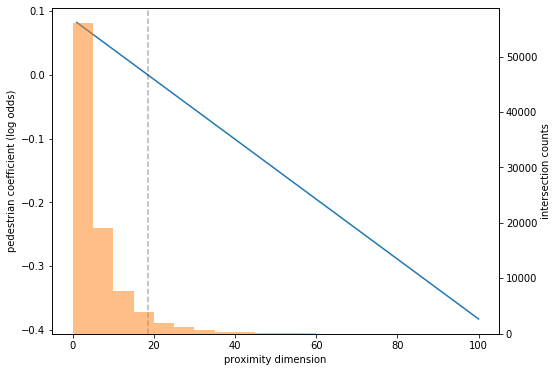

Pedestrian coefficient becomes negative for Proximity score over 18.5.
5946 (10.8%) of steets have a Proximity score over that threshold.


In [59]:
x = range(1,101)
peds_coeff = logit_interaction.params['PEDS3_norm'] + logit_interaction.params['PEDS3_norm:PROX3_norm']*x

fig, ax = plt.subplots(1,1,figsize=(8,6), sharey=True)

ax.plot(x,peds_coeff)

ax.set_xlabel('proximity dimension')
ax.set_ylabel('pedestrian coefficient (log odds)')

ax2 = ax.twinx()

segs_scores['PROX3_norm'].hist(ax=ax2, grid=False, color='tab:orange', alpha=0.5, bins=20)
ax2.set_ylabel('intersection counts')

zero = -logit_interaction.params['PEDS3_norm']/logit_interaction.params['PEDS3_norm:PROX3_norm']
ax.axvline(zero, c='k', alpha=0.3, ls='--')

plt.show()

over_zero = ((segs_scores['PROX3_norm'] > zero).value_counts()[True])

print('''Pedestrian coefficient becomes negative for Proximity score over {:.1f}.
{} ({:.1f}%) of steets have a Proximity score over that threshold.'''.format(zero, over_zero, over_zero/len(X_2)*100))

In [113]:
def plotProbabilityInteraction(ax, X, model, var, model_name, interaction_var, interaction_var_value, is_dim=True):
    #get units from file
    units = pd.read_csv('variables_units.csv', index_col='var').to_dict('index')
    
    #Get stats for each variable
    stats = X.describe().T
    
    #Get model coefficients
    coefs = model.params

    #Get list of other variables in the model (all but the one we are ploting)
    other_vars = list(coefs[1:].index)
    other_vars.remove(var)
    other_vars.remove(interaction_var)
    
    #Calculate the odds for each level of the variable we want, keeping the others at their mean (+- 1std)
    if (is_dim):
        x = range(1,101)
    else:
        x = range(int(np.floor(stats.loc[var,'min'])), int(np.ceil(stats.loc[var,'max'])))
    odds_mean = np.exp(coefs[0] + np.sum(coefs[other_vars]*stats.loc[other_vars,'mean']) + \
                       (coefs[var+':'+interaction_var]*interaction_var_value + coefs[var])*x + coefs[interaction_var]*interaction_var_value)
    
    odds_std1 = np.exp(coefs[0] + np.sum(coefs[other_vars]*(stats.loc[other_vars,'mean']+stats.loc[other_vars,'std'])) + \
                       (coefs[var+':'+interaction_var]*interaction_var_value + coefs[var])*x + coefs[interaction_var]*interaction_var_value)
    odds_std2 = np.exp(coefs[0] + np.sum(coefs[other_vars]*(stats.loc[other_vars,'mean']-stats.loc[other_vars,'std'])) + \
                       (coefs[var+':'+interaction_var]*interaction_var_value + coefs[var])*x + coefs[interaction_var]*interaction_var_value)

    #Transform to probability
    p_mean = odds_mean/(1+odds_mean)
    p_std1 = odds_std1/(1+odds_std1)
    p_std2 = odds_std2/(1+odds_std2)

    if (is_dim):
        ax.plot(x, p_mean, label=model_name)
        ax.fill_between(x, p_std1, p_std2, alpha=0.1)
    else:
        ax.plot(x, p_mean, label=model_name, c='tab:orange')
        ax.fill_between(x, p_std1, p_std2, alpha=0.1, color='tab:orange')
    
    #Actual min max of the dimension
    if (is_dim):
        ax.axvline(stats.loc[var,'min'], ls='--', alpha=0.2, color='k')
        ax.axvline(stats.loc[var,'max'], ls='--', alpha=0.2, color='k')
    
    ax.set_title('Probability of collision when {} changes\nkeeping all other variables constant at their average level'.format(units[var]['name']))
    ax.set_ylabel('prob of collision')
    ax.set_xlabel('dimension value')

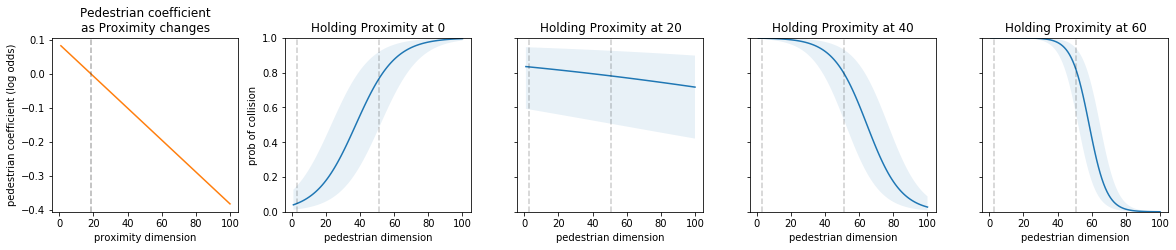

In [133]:
x = range(1,101)
peds_coeff = logit_interaction.params['PEDS3_norm'] + logit_interaction.params['PEDS3_norm:PROX3_norm']*x

fig, axes = plt.subplots(1,5,figsize=(20,3.2))
plt.subplots_adjust(wspace=0.25)

ax = axes[0]

ax.plot(x,peds_coeff, c='tab:orange')

ax.set_xlabel('proximity dimension')
ax.set_ylabel('pedestrian coefficient (log odds)')
ax.set_title('Pedestrian coefficient\nas Proximity changes')

zero = -logit_interaction.params['PEDS3_norm']/logit_interaction.params['PEDS3_norm:PROX3_norm']
ax.axvline(zero, c='k', alpha=0.3, ls='--')

for i in range(1,5):
    ax = axes[i]
    prox_value = (i-1)*20
    plotProbabilityInteraction(ax, X_2, logit_interaction, 'PEDS3_norm', '', 'PROX3_norm', prox_value, is_dim=True)
    ax.set_title('Holding Proximity at {}'.format(prox_value))
    ax.set_xlabel('pedestrian dimension')
    ax.set_ylim([0,1])
    
    if i > 1:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        

plt.show()

In [55]:
segs_shp = gpd.read_file('../Data/road_network_data/osm/osm_w_collisions/edges/edges.shp').to_crs({'init': 'epsg:2263'})
segs_shp = pd.merge(segs_shp, segs_scores, on='id')

In [56]:
segs_shp['PROX3_norm_cut'] = segs_shp['PROX3_norm'] > (-logit_interaction.params['PEDS3_norm']/logit_interaction.params['PEDS3_norm:PROX3_norm'])

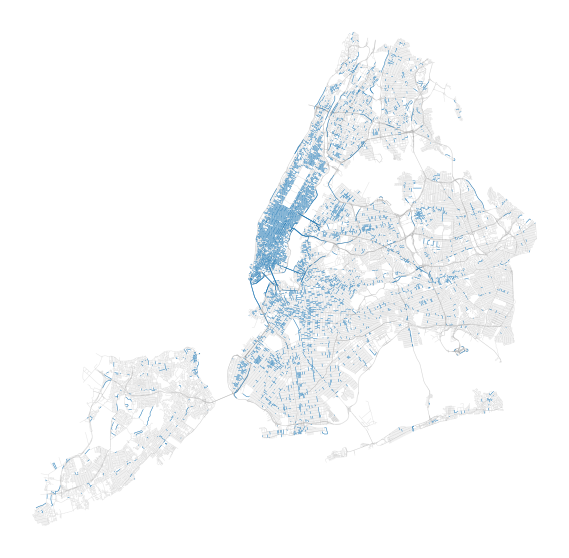

In [57]:
fig, ax = plt.subplots(1,1,figsize=(10,10))

segs_shp[~segs_shp['PROX3_norm_cut']].plot(ax=ax, color='grey', alpha=0.2, lw=.5)
segs_shp[segs_shp['PROX3_norm_cut']].plot(ax=ax, lw=.5)

ax.axis('off')
plt.show()

**Note:** This map shows where an increase in Pedestrian score reduces the likelihood of collision, because Proximity is high.

#### SoP dimension prioritization

In [60]:
reportLogitInterpretation(logit_interaction).loc[np.abs(logit_interaction.params[ind_variables]).sort_values(ascending=False).index,:]

,exp(coef),pvalue,[0.025,0.975],interpretation
PROX3_norm,1.276796,0.000,1.251071,1.303051,a 1 unit increase in Proximity dimension is associated with a 27.7% change in the odds of collision
CONN5_norm,0.913667,0.000,0.901652,0.925843,a 1 unit increase in Connectivity dimension is associated with a -8.6% change in the odds of collision
PEDS3_norm,1.090817,0.000,1.079689,1.102061,a 1 unit increase in Pedestrian dimension is associated with a 9.1% change in the odds of collision
AESTTOT3_norm,0.964271,0.000,0.954562,0.974078,a 1 unit increase in Aesthetic dimension is associated with a -3.6% change in the odds of collision
TRAFFIC5_norm,0.981591,0.000,0.975435,0.987785,a 1 unit increase in Traffic dimension is associated with a -1.8% change in the odds of collision
DENS2_norm,0.992123,0.000,0.989544,0.994709,a 1 unit increase in Density dimension is associated with a -0.8% change in the odds of collision
SAFE_norm,1.007763,0.000,1.004269,1.011269,a 1 unit increase in Safety dimension is associated with a 0.8% change in the odds of collision
PAF2_norm,0.995937,0.386,0.986817,1.005142,a 1 unit increase in Recreation dimension is associated with a -0.4% change in the odds of collision
PARKS2_norm,1.003778,0.182,0.998232,1.009355,a 1 unit increase in Parks dimension is associated with a 0.4% change in the odds of collision
FORM3_norm,0.999966,0.992,0.993627,1.006345,a 1 unit increase in Form dimension is associated with a -0.0% change in the odds of collision


**Note:** This table should be used to prioritize SoP dimensions that impact collisions the most. However, the coefficients for Pedestrian and Proximity should not be taken from here since they are moderated by the interaction term.

### Part 6: Do Train/Test split, train the last model and see how it performs for prediction.

In [61]:
intersections_train, intersections_test, y_train, y_test = train_test_split(intersections, y, test_size=0.33, random_state=42)

In [62]:
logit_interaction_train = smf.logit(formula=formula, data = intersections_train).fit()
logit_interaction_train.summary()

Optimization terminated successfully.
         Current function value: 0.438348
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      Collision_Occured   No. Observations:                36957
Model:                          Logit   Df Residuals:                    36936
Method:                           MLE   Df Model:                           20
Date:                Tue, 23 Jul 2019   Pseudo R-squ.:                  0.3432
Time:                        19:54:02   Log-Likelihood:                -16200.
converged:                       True   LL-Null:                       -24665.
                                        LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.6497      0.646     -2.555      0.011      -2.915      -0.384
FORM3_norm               -0.0007      0.004     -0.181      0.856      -0.009       0.007
DENS2_norm               -0.0092      0.002     -5.655      0.000      -0.012      -0.006
CONN5_norm               -0.0906      0.008    -10.902      0.000      -0.107      -0.074
PROX3_norm                0.2558      0.013     20.394      0.000       0.231       0.280
PARKS2_norm               0.0042      0.003      1.210      0.226      -0.003       0.011
PAF2_norm                -0.0028      0.006     -0.479      0.632      -0.014       0.009
PEDS3_norm                0.0869      0.006     13.558      0.000       0.074       0.100
TRAFFIC5_norm            -0.0164      0.004     -4.116      0.000      -0.024      -0.009
AESTTOT3_norm            -0.0337      0.006     -5.293      0.000      -0.046      -0.021
SAFE_norm                 0.0101      0.002      4.667      0.000       0.006       0.014
PEDS3_norm:PROX3_norm    -0.0050      0.001     -9.564      0.000      -0.006      -0.004
med_inc                  -0.0671      0.004    -15.481      0.000      -0.076      -0.059
norm_res_p                0.0138      0.001     23.685      0.000       0.013       0.015
norm_work_                0.0079      0.002      3.328      0.001       0.003       0.012
sub_dist                 -0.0416      0.003    -13.249      0.000      -0.048      -0.035
Num_Streets               1.0128      0.026     38.998      0.000       0.962       1.064
Num_Lanes                 0.8324      0.028     29.514      0.000       0.777       0.888
Num_Park_Lanes            0.5110      0.039     13.174      0.000       0.435       0.587
Speed_Limit              -0.0078      0.004     -1.791      0.073      -0.016       0.001
Bike_Lanes               -0.0258      0.018     -1.403      0.161      -0.062       0.010
=========================================================================================
"""

**Note:** Coefficients change a little but not substantially.

In [63]:
y_pred = (logit_interaction_train.predict(intersections_test) > 0.5).astype(int)

In [64]:
y_pred.value_counts()/len(y_pred)

0    0.656229
1    0.343771
dtype: float64

In [65]:
y_test.value_counts()/len(y_pred)

0    0.615524
1    0.384476
Name: Collision_Occured, dtype: float64

In [66]:
metrics.confusion_matrix(y_test, y_pred)

array([[9690, 1515],
       [2256, 4743]])

In [67]:
metrics.accuracy_score(y_test, y_pred)

0.7928477257745551

In [68]:
metrics.precision_score(y_test, y_pred)

0.7579098753595398

In [69]:
metrics.recall_score(y_test, y_pred)

0.67766823831976

In [70]:
metrics.f1_score(y_test, y_pred)

0.7155465037338764

### Part 7: Compare with Random Forest Classification

In [72]:
rfc = RandomForestClassifier(n_estimators=500).fit(intersections_train[ind_variables + control_variables], y_train)

In [73]:
y_pred = rfc.predict(intersections_test[ind_variables + control_variables])

In [74]:
metrics.confusion_matrix(y_test, y_pred)

array([[9688, 1517],
       [2020, 4979]])

In [75]:
metrics.accuracy_score(y_test, y_pred)

0.8057020435069215

In [76]:
metrics.precision_score(y_test, y_pred)

0.7664716748768473

In [77]:
metrics.recall_score(y_test, y_pred)

0.7113873410487213

In [78]:
metrics.f1_score(y_test, y_pred)

0.7379029270100038

**Note:** Random Forest Classifier performs a little better than Logistic Regression but without the explainability of the model. Only a 1% increase in accuracy and precision, and 4% increase in recall.